## Quantitative QC by CV calculation
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we calculate CVs to show the quality of the data.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_max_quant()
data_raw.head()

,Intensity 1_B_C10,Intensity 1_B_C11,Intensity 1_B_C12,Intensity 1_B_C13,Intensity 1_B_C9,Intensity 1_T_D10,Intensity 1_T_D11,Intensity 1_T_D12,Intensity 1_T_D13,Intensity 1_T_D9
Protein IDs,,,,,,,,,,
P0DPI2;A0A0B4J2D5,265300,248290,1878900,289210,0,0,0,0,0,654710
A0AVT1,0,0,440250,139370,0,0,303590,0,0,0
A6NHQ2,126410,0,0,89903,0,263160,0,0,110120,0
A6NI72;P14598;A8MVU1,1246500,1821600,3189500,2912100,1045700,0,0,0,0,0
P62308;A8MWD9,0,305850,0,0,0,0,0,0,0,372880


Now we normalize across runs. Note that following median normalization, we reverse the log2, leaving the data aligned between runs but allowing the most typical coefficient variation calculation.

In [2]:
from numpy import nan
from numpy import log2
from statistics import median

data_log2 = log2(data_raw.replace(0,nan))
#global_median = median(data_log2.apply(lambda series: median(series.dropna())))
data_log2_normalized = data_log2.apply(lambda series: series-median(series.dropna()))#+global_median)
data = data_log2_normalized.apply(lambda series: 2**series)

Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [3]:
import data_utils    
indecies = data.apply(data_utils.check_three_of_each_type, axis=1)
data = data[indecies]
#data.head()

Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [4]:
from scipy.stats import variation
from statistics import mean
import pandas as pd
from numpy import isnan

In [5]:
cell_types = ["1_B", "1_T"]
CVs = {}
for population in cell_types:
    cells_in_population = list(s for s in data.columns.values.tolist() if population in s)
    data_by_type = data[cells_in_population]
    #now we have a dataframe with just one subpopulation
    #Call variation function
    var = data_by_type.apply(variation, axis=1, nan_policy='omit')
    CVs[population] = var
    
    #Here we report an overview
    print (population)
    print ('Mean CV:\t',mean(var))
    print ('Min CV: \t',min(var))
    print ('Max CV: \t',max(var))
    print ('nan:    \t',len([i for i in var if isnan(i)]))
    print ('Zero:    \t',len([i for i in var if i==0]))
    var_under_20 = len([i for i in var if i < .2])
    var_under_10 = len([i for i in var if i < .1])
    count = len(var)#len([i for i in var if i!=0])
    print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/count))
    print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/count))
    print (count)
    print ()
    

CVs = pd.DataFrame.from_dict(CVs)    

1_B
Mean CV:	 0.39464678863136526
Min CV: 	 0.021266332923464658
Max CV: 	 1.2822455238776989
nan:    	 0
Zero:    	 0
Under 10%:	 13 	0.02
Under 20%:	 126 	0.18
699

1_T
Mean CV:	 0.3310113687470705
Min CV: 	 0.014231914527568579
Max CV: 	 1.7342506885851763
nan:    	 0
Zero:    	 0
Under 10%:	 34 	0.05
Under 20%:	 196 	0.28
699



Next, we will visualize the data, which shows that the majority of proteins have small coefficients of variation.

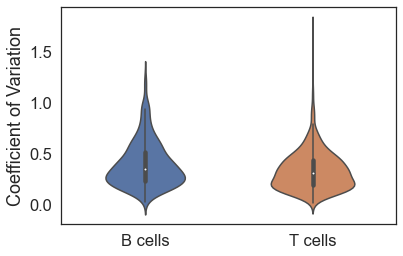

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
figure = sns.violinplot(data=CVs, width=.5)
figure.set_ylabel("Coefficient of Variation")
figure.set_xticklabels(['B cells', 'T cells'])

plt.show()

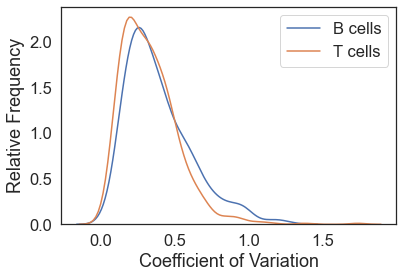

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

sns.set_style("white")
figure = sns.distplot(CVs['1_B'], hist = False, label='B cells')#, width=.5)
figure = sns.distplot(CVs['1_T'], hist = False, label='T cells')#, width=.5)
figure.set_ylabel("Relative Frequency")
figure.set_xlabel("Coefficient of Variation")

figure.legend(['B cells', 'T cells'])
plt.show()

Here we summarize the CVs overall. Note that the CVs were calculated within types and so still represent technical variability, not variation between cell types.

In [7]:
var = CVs.values.flatten()

print ('Mean CV:\t',mean(var))
print ('Min CV: \t',min(var))
print ('Max CV: \t',max(var))
print ('nan:    \t',len([i for i in var if isnan(i)]))
print ('Zero:    \t',len([i for i in var if i==0]))
    
var_under_20 = len([i for i in var if i < .2])
var_under_10 = len([i for i in var if i < .1])
count = len(var)#len([i for i in var if i!=0])
print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/count))
print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/count))

Mean CV:	 0.3628290786892179
Min CV: 	 0.014231914527568579
Max CV: 	 1.7342506885851763
nan:    	 0
Zero:    	 0
Under 10%:	 47 	0.03
Under 20%:	 322 	0.23


This shows accuracy in repeatedly characterizing each cell type.